In [30]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'

In [31]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.parametrizations import spectral_norm
from torch.autograd import Variable
from torchvision import datasets, transforms, utils
import seaborn as sns
import matplotlib.pyplot as plt
from dataTransformation import labels4clients, distribute_data_labels4clients, distribute_data_per_client_edited
from gan_model import Discriminator, Generator, initialize_weights
from network import Server, Worker
from torch.utils.data import Dataset, DataLoader
from utils import Logger
from fid_score import *
from inception import *
import math

In [32]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)
torch.use_deterministic_algorithms(True)
# torch.backends.cudnn.deterministic = True

In [33]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
dev = torch.device(dev)

In [34]:
NUM_WORKERS = 2
CLASSES_PER_USER = 2
WORKER_OVERRIDE = True # overrides other workers weights with the chosen worker
NUM_EPOCHS = 200
BATCH_SIZE = 16

LEARNING_RATE_D = 2e-4
LEARNING_RATE_G = 2e-4
B1 = 0.5
B2 = 0.999

NOISE_DIM = 128
FID_BATCH_SIZE = 20
NUM_UNIQUE_USERS = NUM_WORKERS

In [35]:
limit_classes = True
Discriminator_trainig_iterations = 3
chosen_strategy = 1
trainig_strategies = {0:'fed_avg', 1:'weighted_avg_most',2:'weighted_avg_least', 3:'most_forgiving', 4:'least_forgiving'}
trainig_strategies = trainig_strategies[chosen_strategy]

In [36]:
trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# trans_cifar = transforms.Compose([transforms.ToTensor()])
dataset = datasets.CIFAR10(root='./datasets/cifar/', train=True, download=True, transform=trans_cifar)
dataset_test = datasets.CIFAR10(root='./datasets/cifar/', train=False, download=True, transform=trans_cifar)
dataloader_one = torch.utils.data.DataLoader(dataset, shuffle = True,batch_size=BATCH_SIZE)
dataloader_test = torch.utils.data.DataLoader(dataset_test, shuffle = True,batch_size=10000)

MAX_WORKER_SAMPLE = len(dataset)/NUM_WORKERS

Files already downloaded and verified


KeyboardInterrupt: 

In [ ]:
num_classes = 10


dictionary = labels4clients(num_classes,CLASSES_PER_USER,NUM_WORKERS,NUM_UNIQUE_USERS,random_seed=False)

if limit_classes:
    worker1_classes = []
    worker1_classes.append(dataset.class_to_idx['truck'])
    worker1_classes.append(dataset.class_to_idx['automobile'])
    print(worker1_classes)

    worker2_classes = []
    worker2_classes.append(dataset.class_to_idx['dog'])
    worker2_classes.append(dataset.class_to_idx['cat'])
    print(worker2_classes)

    dictionary = {}
    for i in worker1_classes:
        if i in dictionary:
            dictionary[i].append(0)
        else:
            dictionary[i]= [0]
    for i in worker2_classes:
        if i in dictionary:
            dictionary[i].append(1)
        else:
            dictionary[i]= [1]

print(dictionary)

[9, 1]
[5, 3]
{9: [0], 1: [0], 5: [1], 3: [1]}


In [ ]:
for img in dataloader_test:
    test_imgs=img[0].to(dev)

In [ ]:
# print(dataset.data[0])
# print(dataset.transforms(dataset.data[0],transforms.ToTensor()))
# print(dataset.transforms(dataset.data[0],trans_cifar))

transformed shape: (3, 32, 32)


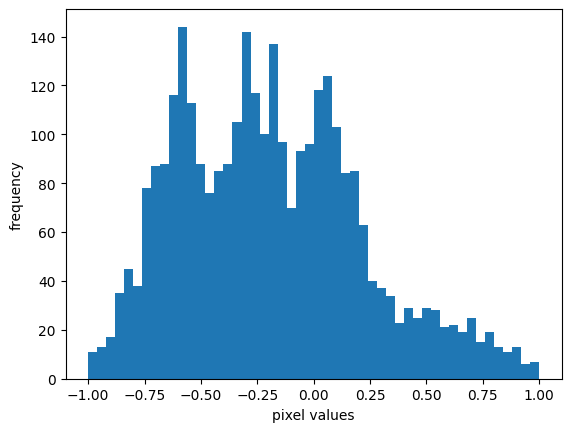

In [ ]:
transformed = trans_cifar(dataset.data[0]).cpu().detach().numpy()
print("transformed shape:", transformed.shape)
plt.figure('normalized data')
plt.hist(transformed.ravel(), bins=50, density=False)
plt.xlabel("pixel values")
plt.ylabel("frequency")
plt.show()

In [ ]:
# print(dataset.data.shape)
# print(type(dataset))
# print(dataloader_one.dataset.data.shape)
# x,_ = dataloader_one.dataset[0]
# print(x.shape)
# print(x)

In [ ]:
x_train_normalized_np = np.empty((dataset.data.shape[0],dataset.data.shape[3],dataset.data.shape[1],dataset.data.shape[2]))
print("train datatset shape:",x_train_normalized_np.shape)
for i in range(len(dataset)):
    x_train_normalized_np[i] = trans_cifar(dataset.data[i])

train datatset shape: (50000, 3, 32, 32)


In [ ]:
x_train_normalized_np[0][0].shape

(32, 32)

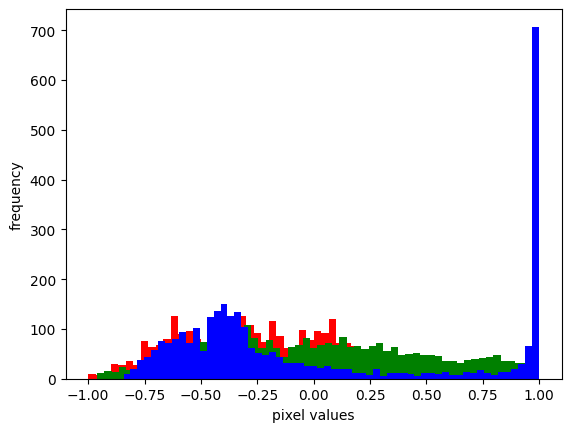

In [ ]:
plt.figure('normalized data')
bin_size = 60
plt.hist(x_train_normalized_np[:][0].ravel(),color='r', bins=bin_size, density=False)
plt.hist(x_train_normalized_np[:][1].ravel(),color='g', bins=bin_size, density=False)
plt.hist(x_train_normalized_np[:][2].ravel(),color='b', bins=bin_size, density=False)
plt.xlabel("pixel values")
plt.ylabel("frequency")
plt.show()

In [ ]:
# x_train = np.asarray(dataset.data)
y_train = np.asarray(dataset.targets)
x_client_list, y_client_list = distribute_data_per_client_edited(x_train_normalized_np,y_train,dictionary,CLASSES_PER_USER,random_seed = False, max_samples_per_client = MAX_WORKER_SAMPLE)

In [ ]:
for i, x in enumerate(x_client_list):
    print(f'worker#{i} data count: {len(x)}')

worker#0 data count: 10000
worker#1 data count: 10000


In [ ]:
# def getDist(y,class_list,user_num):
#     ax = sns.countplot(x=y)
#     ax.set(title="Count of data classes for %s" %user_num)
#     plt.show()

In [ ]:
def getDist(y,class_list,user_num):
    ax = sns.barplot(x=class_list,y=y)
    ax.set(title="Count of data classes for %s" %user_num)
    plt.show()

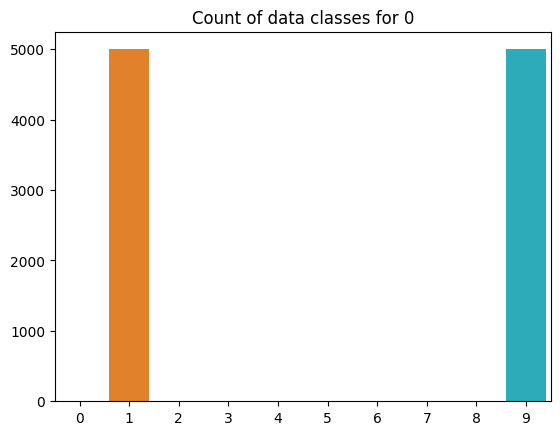

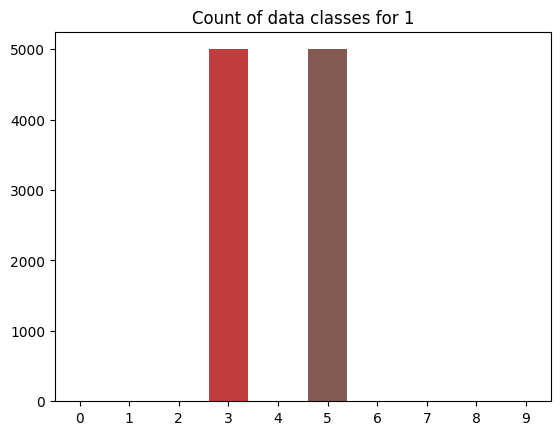

total used data 20000


In [ ]:
total_data = 0
class_list = [i for i in range(num_classes)]
for i in range (len(x_client_list)):
    length = len(y_client_list[i])
    total_data+= length
    y_list = np.bincount(y_client_list[i],minlength=num_classes)
    getDist(y_list,class_list,i)
print("total used data", total_data)

In [ ]:
fic_model = InceptionV3().to(dev)

In [ ]:
main_server = Server(0,LEARNING_RATE_G,B1,B2,dev)
# initialize_weights(main_server.generator)
# initialize_weights(main_server.global_disc)
main_server.generator.train()
main_server.global_disc.train()
workers = []
workers_weights= []
copy_workers = False
for i in range(NUM_WORKERS):
    worker = Worker(i,LEARNING_RATE_D,B1,B2,dev)
    # x_clinet_list[i] = np.transpose(x_clinet_list[i],(0, 3, 1, 2))
    if copy_workers:
        worker.load_worker_data(x_client_list[0], y_client_list[0])
    else:
        worker.load_worker_data(x_client_list[i], y_client_list[i]) 
    # initialize_weights(worker.discriminator)
    worker.discriminator.train()
    workers.append(worker)
    workers_weights.append(worker.discriminator.state_dict())
    
# summary(main_server.generator,(128,1,1))
# summary(workers[0].discriminator,(3,32,32))

In [ ]:
# # code to make all the workers the same
# workers_weights= []
# for worker in workers:
#     worker.discriminator = workers[-1].discriminator
#     workers_weights.append(worker.discriminator.state_dict())

In [ ]:
criterion = nn.MSELoss()
fixed_noise = torch.randn(36, NOISE_DIM, 1, 1).to(dev) # to use for generating output images

worker_loaders = []

for worker in workers:
    # print(worker.x_data.shape)
    worker_loaders.append([])
    for batch_id, real in enumerate(DataLoader(dataset=worker.x_data,batch_size=BATCH_SIZE)):
        worker_loaders[-1].append(real)

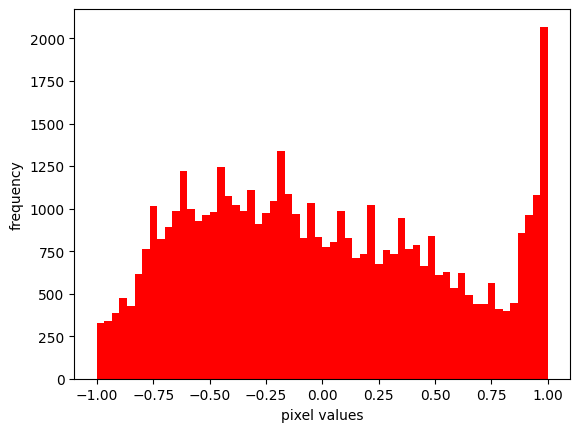

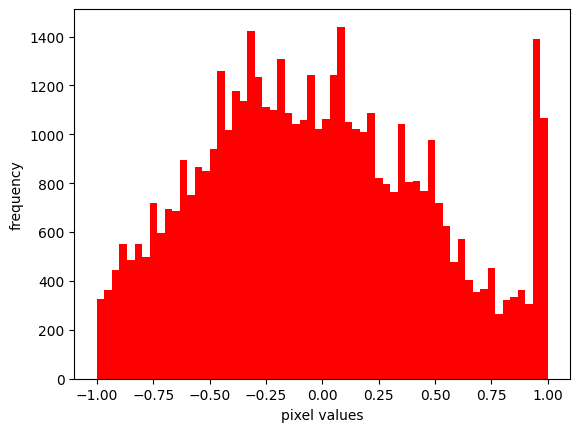

In [ ]:
for worker in worker_loaders:
    plt.figure('normalized data')
    plt.hist(worker[:][1].ravel(),color='r', bins=bin_size, density=False)
    # plt.hist(x_train_normalized_np[:][1].ravel(),color='g', bins=bin_size, density=False)
    # plt.hist(x_train_normalized_np[:][2].ravel(),color='b', bins=bin_size, density=False)
    plt.xlabel("pixel values")
    plt.ylabel("frequency")
    plt.show()

In [ ]:
logger = Logger(model_name='F2U',data_name='CIFAR10')
param_list = ["NUM_WORKERS", "CLASSES_PER_USER", "NUM_EPOCHS", "BATCH_SIZE",
"Discriminator_trainig_iterations","LEARNING_RATE_D", "LEARNING_RATE_G", "trainig_strategies", "WORKER_OVERRIDE","limit_classes"]
global_params = list(globals().items()) 
logger.log_params(param_list,global_params)

NUM_WORKERS=  2

CLASSES_PER_USER=  2

WORKER_OVERRIDE=  True

NUM_EPOCHS=  200

BATCH_SIZE=  16

LEARNING_RATE_D=  0.0002

LEARNING_RATE_G=  0.0002

limit_classes=  True

Discriminator_trainig_iterations=  3

trainig_strategies=  weighted_avg_most



100%|██████████| 1/1 [00:00<00:00,  7.09it/s]


Epoch [0/200] Batch 0/625                 Loss D: 0.0200, loss G: 1.0044, FID Score: 231.2


100%|██████████| 1/1 [00:00<00:00,  6.10it/s]


Epoch [0/200] Batch 100/625                 Loss D: 0.0188, loss G: 0.9922, FID Score: 237.6


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


Epoch [0/200] Batch 200/625                 Loss D: 0.0198, loss G: 0.9944, FID Score: 232.8


100%|██████████| 1/1 [00:00<00:00,  6.33it/s]


Epoch [0/200] Batch 300/625                 Loss D: 0.0099, loss G: 1.1008, FID Score: 237.7


100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


Epoch [0/200] Batch 400/625                 Loss D: 0.0158, loss G: 1.0541, FID Score: 227.6


100%|██████████| 1/1 [00:00<00:00,  6.40it/s]


Epoch [0/200] Batch 500/625                 Loss D: 0.0123, loss G: 0.9286, FID Score: 239.9


100%|██████████| 1/1 [00:00<00:00,  6.29it/s]


Epoch [0/200] Batch 600/625                 Loss D: 0.0246, loss G: 1.0155, FID Score: 255.1
hi


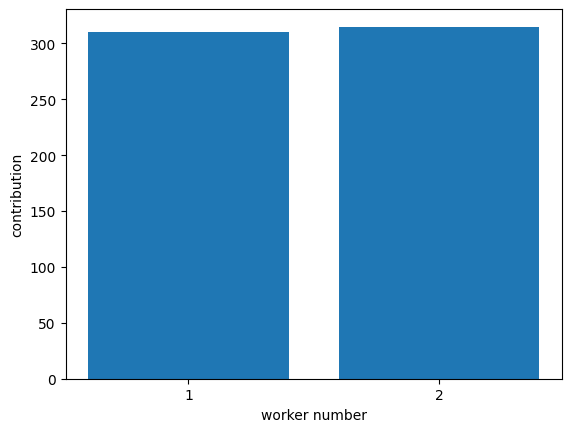

100%|██████████| 1/1 [00:00<00:00,  7.09it/s]


Epoch [1/200] Batch 0/625                 Loss D: 0.0249, loss G: 1.1267, FID Score: 229.4


100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


Epoch [1/200] Batch 100/625                 Loss D: 0.0252, loss G: 0.9011, FID Score: 220.5


100%|██████████| 1/1 [00:00<00:00,  6.24it/s]


Epoch [1/200] Batch 200/625                 Loss D: 0.0289, loss G: 0.9032, FID Score: 251.0


100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


Epoch [1/200] Batch 300/625                 Loss D: 0.1285, loss G: 0.7069, FID Score: 232.1


100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


Epoch [1/200] Batch 400/625                 Loss D: 0.0413, loss G: 1.0133, FID Score: 238.7


100%|██████████| 1/1 [00:00<00:00,  6.28it/s]


Epoch [1/200] Batch 500/625                 Loss D: 0.0301, loss G: 1.1392, FID Score: 244.0


100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


Epoch [1/200] Batch 600/625                 Loss D: 0.0266, loss G: 0.9162, FID Score: 230.5
hi


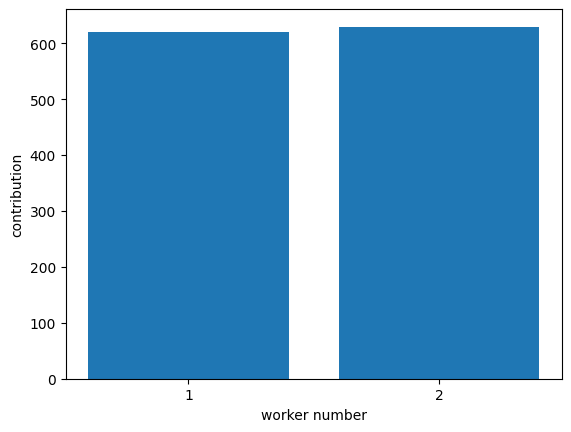

100%|██████████| 1/1 [00:00<00:00,  7.03it/s]


Epoch [2/200] Batch 0/625                 Loss D: 0.0156, loss G: 1.0435, FID Score: 237.0


100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


Epoch [2/200] Batch 100/625                 Loss D: 0.0415, loss G: 0.9705, FID Score: 243.3


100%|██████████| 1/1 [00:00<00:00,  6.94it/s]


Epoch [2/200] Batch 200/625                 Loss D: 0.0208, loss G: 0.9004, FID Score: 246.8


100%|██████████| 1/1 [00:00<00:00,  6.37it/s]


Epoch [2/200] Batch 300/625                 Loss D: 0.0188, loss G: 1.0140, FID Score: 239.2


100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


Epoch [2/200] Batch 400/625                 Loss D: 0.0273, loss G: 0.9391, FID Score: 223.8


100%|██████████| 1/1 [00:00<00:00,  6.10it/s]


Epoch [2/200] Batch 500/625                 Loss D: 0.0421, loss G: 0.7865, FID Score: 230.1


100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


Epoch [2/200] Batch 600/625                 Loss D: 0.0269, loss G: 0.7383, FID Score: 238.1
hi


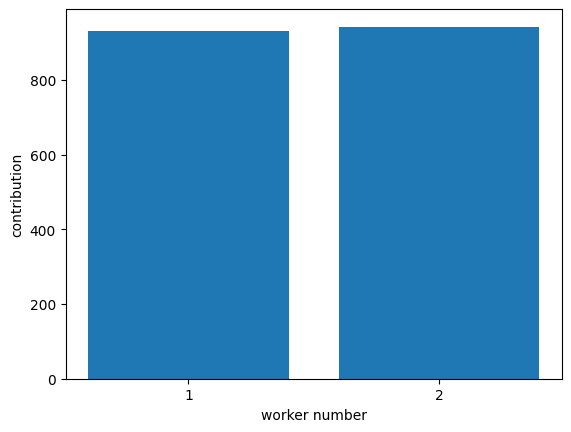

100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


Epoch [3/200] Batch 0/625                 Loss D: 0.0271, loss G: 0.8259, FID Score: 215.4


100%|██████████| 1/1 [00:00<00:00,  6.33it/s]


Epoch [3/200] Batch 100/625                 Loss D: 0.0242, loss G: 0.8847, FID Score: 239.1


100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


Epoch [3/200] Batch 200/625                 Loss D: 0.0201, loss G: 0.9499, FID Score: 255.5


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


Epoch [3/200] Batch 300/625                 Loss D: 0.0296, loss G: 0.9256, FID Score: 231.1


100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


Epoch [3/200] Batch 400/625                 Loss D: 0.0218, loss G: 0.8250, FID Score: 241.5


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


Epoch [3/200] Batch 500/625                 Loss D: 0.0283, loss G: 1.1498, FID Score: 257.3


100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


Epoch [3/200] Batch 600/625                 Loss D: 0.0238, loss G: 0.8989, FID Score: 229.4
hi


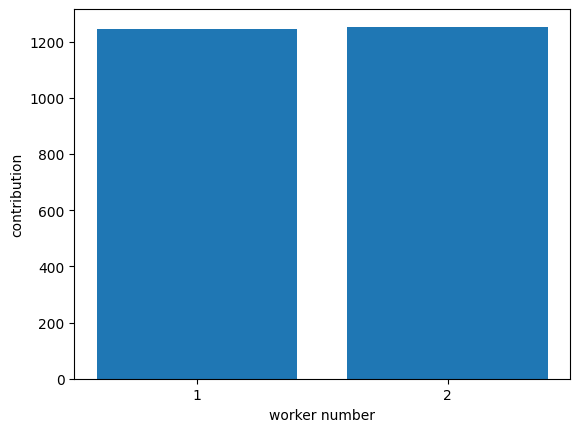

100%|██████████| 1/1 [00:00<00:00,  6.10it/s]


Epoch [4/200] Batch 0/625                 Loss D: 0.0240, loss G: 0.9930, FID Score: 228.6


100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


Epoch [4/200] Batch 100/625                 Loss D: 0.0371, loss G: 0.8762, FID Score: 235.5


100%|██████████| 1/1 [00:00<00:00,  6.29it/s]


Epoch [4/200] Batch 200/625                 Loss D: 0.0295, loss G: 0.9636, FID Score: 238.1


100%|██████████| 1/1 [00:00<00:00,  6.21it/s]


Epoch [4/200] Batch 300/625                 Loss D: 0.0299, loss G: 1.0124, FID Score: 241.7


100%|██████████| 1/1 [00:00<00:00,  6.94it/s]


Epoch [4/200] Batch 400/625                 Loss D: 0.0291, loss G: 1.0053, FID Score: 238.4


100%|██████████| 1/1 [00:00<00:00,  6.37it/s]


Epoch [4/200] Batch 500/625                 Loss D: 0.0479, loss G: 0.7717, FID Score: 234.8


100%|██████████| 1/1 [00:00<00:00,  6.94it/s]


Epoch [4/200] Batch 600/625                 Loss D: 0.0496, loss G: 0.8666, FID Score: 230.4
hi


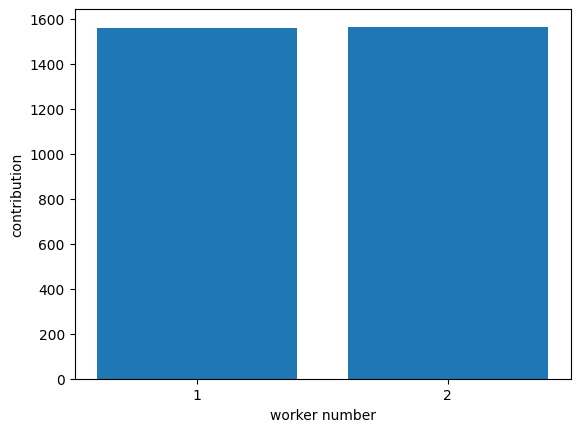

100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


Epoch [5/200] Batch 0/625                 Loss D: 0.0382, loss G: 0.9464, FID Score: 230.2


100%|██████████| 1/1 [00:00<00:00,  6.37it/s]


Epoch [5/200] Batch 100/625                 Loss D: 0.0333, loss G: 0.8593, FID Score: 246.9


100%|██████████| 1/1 [00:00<00:00,  6.29it/s]


Epoch [5/200] Batch 200/625                 Loss D: 0.0345, loss G: 0.8866, FID Score: 223.2


KeyboardInterrupt: 

In [ ]:
# main training loop for F2U (trial == FALSE)
start = 0
end = start + NUM_EPOCHS
end = NUM_EPOCHS

soft_max = nn.Softmax(dim=0)
worker_contribution_cum = torch.zeros(NUM_WORKERS)

for epoch in range(start,end):
    for batch_id in range(len(worker_loaders[0])):

        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
        fake = main_server.generator(noise)
        
        for disc_train_iter in range(Discriminator_trainig_iterations):
            highest_loss = 0
            lowest_loss = math.inf
            chosen_discriminator = None
            worker_losses = []
            for worker_id, worker in enumerate(workers):
                current_worker_real = worker_loaders[worker_id][batch_id].float().to(dev)

                # print('worker ({}) datasum:'.format(worker_id),sum(current_worker_real.flatten()).item())
                # print(current_worker_real.shape)

                worker.d_optimizer.zero_grad()
            
                ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
                current_disc_real = worker.discriminator(current_worker_real).reshape(-1)
                worker.loss_disc_real = criterion(current_disc_real, torch.ones_like(current_disc_real))
                # print('real_classification:', round(sum(current_disc_real).item(),6),'real_loss:',round(worker.loss_disc_real.item(),6))
                current_disc_fake = worker.discriminator(fake.detach()).reshape(-1)
                worker.loss_disc_fake = criterion(current_disc_fake, torch.zeros_like(current_disc_fake))
                # print('fake_classification:', round(sum(current_disc_fake).item(),6),'fake_loss:',round(worker.loss_disc_fake.item(),6))
                worker.loss_disc = (worker.loss_disc_real + worker.loss_disc_fake) / 2
                
                worker.loss_disc.backward()
                worker.d_optimizer.step()

                workers_weights[worker_id] = worker.discriminator.state_dict()
                worker_losses.append(worker.loss_disc_fake.detach())
                # print(worker.loss_disc_fake, i)
                if highest_loss < worker.loss_disc_fake and trainig_strategies == 'most_forgiving':
                    highest_loss = worker.loss_disc_fake
                    chosen_discriminator = worker_id
                    chosen_worker = workers[chosen_discriminator]
                    
                    

                if lowest_loss > worker.loss_disc_fake and trainig_strategies == 'least_forgiving' :
                    lowest_loss = worker.loss_disc_fake
                    chosen_discriminator = worker_id
                    chosen_worker = workers[chosen_discriminator]
                   
            # print(f"chosen worker is {chosen_discriminator} with loss of: {highest_loss.item():.4f}")
        
        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        if trainig_strategies in ['fed_avg', 'weighted_avg_most']:
            worker_losses = torch.FloatTensor(worker_losses)
            # print(f"worker_losses before: {worker_losses}")
            worker_losses_sm = soft_max(worker_losses)
            # print(worker_losses_sm)
            worker_contribution_cum += worker_losses_sm
        elif trainig_strategies == 'weighted_avg_least':
            # print(f"worker_losses before: {worker_losses}")
            worker_losses = -1*torch.FloatTensor(worker_losses)
            # print(f"worker_losses after: {worker_losses}")
            worker_losses_sm = soft_max(worker_losses)
            # print(f"worker_losses_sm: {worker_losses_sm}")
            worker_contribution_cum += worker_losses_sm

        # print(f"worker_losses after softmax: {worker_losses_sm}")

        # worker_total_weights1 = []
        # for worker in workers:
        #     weight_sum = 0
        #     for i, p in enumerate(worker.discriminator.parameters()):
        #         output = sum(p.detach().cpu().numpy().flatten())
        #         weight_sum += output
        #     worker_total_weights1.append(round(weight_sum,1))

        main_server.g_optimizer.zero_grad()

        if trainig_strategies == 'fed_avg':
            avg_w = main_server.fed_average(workers_weights)
            main_server.global_disc.load_state_dict(avg_w)
            for worker in workers:
                worker.discriminator.load_state_dict(avg_w)
            output = main_server.global_disc(fake).reshape(-1)
            chosen_worker = workers[0]
        elif trainig_strategies in ['weighted_avg_most','weighted_avg_least']:
            avg_w = main_server.weighted_fed_average(workers_weights,worker_losses_sm)
            main_server.global_disc.load_state_dict(avg_w)
            for worker in workers:
                worker.discriminator.load_state_dict(avg_w)
            output = main_server.global_disc(fake).reshape(-1)
            chosen_worker = workers[0]
        else:
            worker_contribution_cum[chosen_discriminator]+=1
            if WORKER_OVERRIDE:
                for worker in workers:
                    worker.discriminator.load_state_dict(chosen_worker.discriminator.state_dict())
            output = chosen_worker.discriminator(fake).reshape(-1)
        main_server.loss_gen = criterion(output, torch.ones_like(output))
        
        main_server.loss_gen.backward()
        # check weights of all workers before and after

        main_server.g_optimizer.step()

        # worker_total_weights2 = []
        # for worker in workers:
        #     weight_sum = 0
        #     for i, p in enumerate(worker.discriminator.parameters()):
        #         output = sum(p.detach().cpu().numpy().flatten())
        #         weight_sum += output
        #     worker_total_weights2.append(round(weight_sum,1))
        
        # diff = []
        # for i, curr_weight in enumerate(worker_total_weights2):
        #     diff.append(abs(curr_weight-worker_total_weights1[i]))
        # print("before g_optimizer:", worker_total_weights1, "after g_optimizer:", worker_total_weights2, "diff:", diff)

        with torch.no_grad():
            logger.log_workers(workers,epoch,batch_id,len(worker_loaders[0]))
            logger.log(chosen_worker.loss_disc.item(),main_server.loss_gen.item(),chosen_worker.loss_disc_real, chosen_worker.loss_disc_fake,epoch,batch_id,len(worker_loaders[0]))
        # Print loss
        if batch_id % 100 == 0:
            fid_z = torch.randn(FID_BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
            gen_imgs = main_server.generator(fid_z.detach())
            mu_gen, sigma_gen = calculate_activation_statistics(gen_imgs, fic_model, batch_size=FID_BATCH_SIZE,cuda=True,verbose=False)
            mu_test, sigma_test = calculate_activation_statistics(test_imgs[:FID_BATCH_SIZE], fic_model, batch_size=FID_BATCH_SIZE,cuda=True,verbose=False)
            fid = calculate_frechet_distance(mu_gen, sigma_gen, mu_test, sigma_test)
            logger.log_fid(fid,epoch,batch_id,len(worker_loaders[0]))

            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_id}/{len(worker_loaders[0])} \
                Loss D: {chosen_worker.loss_disc:.4f}, loss G: {main_server.loss_gen:.4f}, FID Score: {fid:.1f}"
            )
        
    with torch.no_grad():
        main_server.generator.eval()
        fake = main_server.generator(fixed_noise)
        main_server.generator.train()
        logger.log_images(fake,len(fake), epoch, batch_id, len(worker_loaders[0]))

    print('hi')
    chosen_w_np = worker_contribution_cum.detach().cpu().numpy()
    ra = range(1,len(chosen_w_np)+1)
    plt.bar(ra,chosen_w_np)
    plt.xticks(ra)
    plt.xlabel('worker number')
    plt.ylabel('contribution')
    plt.savefig('{}/worker_cont.png'.format(logger.writer.logdir))
    plt.show()

    if (epoch+1) % 50 == 0 and epoch != 0:
        logger.save_models(main_server,workers,epoch)

In [ ]:
# plt.bar(range(len(worker_chosen_counter)),worker_chosen_counter)
# plt.xlabel('worker number')
# plt.ylabel('chosen counter')
# plt.show()

In [ ]:
# for testing the total weights
# worker_total_weights1 = []
# for worker in workers:
#     weight_sum = 0
#     for i, p in enumerate(worker.discriminator.parameters()):
#         output = sum(p.detach().cpu().numpy().flatten())
#         weight_sum += output
#     worker_total_weights1.append(round(weight_sum,1))

# worker_total_weights2 = []
# for worker in workers:
#     weight_sum = 0
#     for i, p in enumerate(worker.discriminator.parameters()):
#         output = sum(p.detach().cpu().numpy().flatten())
#         weight_sum += output
#     worker_total_weights2.append(round(weight_sum,1))

# diff = []
# for i, curr_weight in enumerate(worker_total_weights2):
#     diff.append(abs(curr_weight-worker_total_weights1[i]))
# print("before g_optimizer:", worker_total_weights1, "after g_optimizer:", worker_total_weights2, "diff:", diff)


In [ ]:
# # GAN archicture trial (trial == TRUE)
# if trial:
#     start = 0
#     end = start + NUM_EPOCHS
#     for epoch in range(start,end):
#         for i, data in enumerate(dataloader_one):
#             worker = workers[0]
#             noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
#             fake = main_server.generator(noise)
#             real, _ = data

#             ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
            
#             current_disc_real = worker.discriminator(real).reshape(-1)
#             # print('current discriminator real output', current_disc_real)
#             worker.loss_disc_real = criterion(current_disc_real, torch.ones_like(current_disc_real))
#             # print('worker loss_disc_real output', current_disc_real)
#             current_disc_fake = worker.discriminator(fake.detach()).reshape(-1)
#             worker.loss_disc_fake = criterion(current_disc_fake, torch.zeros_like(current_disc_fake))
#             worker.loss_disc = (worker.loss_disc_real + worker.loss_disc_fake) / 2
#             worker.discriminator.zero_grad()
#             worker.loss_disc.backward()
#             # total_norm_d =0
#             # for p in list(filter(lambda p: p.grad is not None, worker.discriminator.parameters())):
#             #     total_norm_d += p.grad.detach().data.norm(2).item()** 2
#             # total_norm_d = total_norm_d ** 0.5

#             worker.d_optimizer.step()

#             ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
            
#             output = worker.discriminator(fake).reshape(-1)
#             main_server.loss_gen = criterion(output, torch.ones_like(output))
#             main_server.generator.zero_grad()
#             main_server.loss_gen.backward()

#             # total_norm_g =0
#             # for p in list(filter(lambda p: p.grad is not None, main_server.generator.parameters())):
#             #     total_norm_g += p.grad.detach().data.norm(2).item()** 2
#             # total_norm_g = total_norm_g ** 0.5

#             main_server.g_optimizer.step()


#             logger.log(worker.loss_disc.item(),main_server.loss_gen.item(),worker.loss_disc_real, worker.loss_disc_fake,epoch,i,len(dataloader_one))

#             # Print loss
#             if i % 100 == 0:    
#                 fid_z = torch.randn(FID_BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
#                 gen_imgs = main_server.generator(fid_z.detach())
#                 mu_gen, sigma_gen = calculate_activation_statistics(gen_imgs, fic_model, batch_size=FID_BATCH_SIZE,cuda=True)
#                 mu_test, sigma_test = calculate_activation_statistics(test_imgs[:FID_BATCH_SIZE], fic_model, batch_size=FID_BATCH_SIZE,cuda=True)
#                 fid = calculate_frechet_distance(mu_gen, sigma_gen, mu_test, sigma_test)
#                 logger.log_fid(fid,epoch,i,len(dataloader_one))

#                 print(
#                     f"Epoch [{epoch}/{end}] Batch {i}/{len(dataloader_one)} \
#                     Loss D: {worker.loss_disc:.4f}, loss G: {main_server.loss_gen:.4f}, FID Score: {fid:.1f}"
#                 )

#             if i% 500 == 0:
#                 with torch.no_grad():
#                     fake = main_server.generator(fixed_noise)
#                     logger.log_images(fake,len(fake), epoch, i, len(dataloader_one))
#         if epoch % 50 == 0 and epoch !=0:
#             logger.save_models(main_server,workers,epoch)
